# Embedding People of Informatics

Here, embed individuals in different dimensions, as a form of dimensionality reduction. The following models were used to embed individuals:
1. tf-idf 
    - metadata
    - metadata + pdf
2. topic models 
    - topic model derived from metadata
    - topic model derived using documents in DBLP
    
    
## Methodology
1. Derive the models (for topic models, that is already derived in notebook on [topicModelling](topicModels/notebooks/topicModelling.ipynb).
2. Map individuals to the publications that they have published. (a bipartite graph between publications and individuals)
3. FOR each individual, using the publications for each individual, derive the embedding in the ***new*** space.
4. Calculate metrics such as **similarity** between individuals.

---

## Setup

In [1]:
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import gensim.similarities as sim
import pickle as pkl
import os
DATA_DIR = '../../data/data_schoolofinf/'

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-poster'])

Import tokens for publications

In [3]:
# Tokens from collection
lookup_combined_toks = pd.read_pickle(
    os.path.join(DATA_DIR, 'toks', 'toks.combined.pkl'))

In [4]:
# Filter the list of publications by:
# 1) Number of collaborators for that publication should be at least 2 (otherwise we wont see those authors in the collaboration graph anyway)
# lookup_pub = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_pub.pkl'))
# lookup_pub['num_collab'] = lookup_pub['edges'].apply(lambda x: len(x))
# lookup_pub_atleast2 = lookup_pub.drop(
#     lookup_pub[(lookup_pub.num_collab < 2)].index)

# 2) year of publication
lookup_combined_toks.drop(
    lookup_combined_toks[(lookup_combined_toks.year < 1997)
                         | (lookup_combined_toks.year > 2017)].index,
    inplace=True)

In [5]:
len(lookup_combined_toks)

8028

In [6]:
# Replace empty entries in lookup_combined_toks_rest.toks_pdf2txt with list []
lookup_combined_toks[
    'toks_pdf2txt'] = lookup_combined_toks.toks_pdf2txt.apply(
        lambda x: [] if not len(x) else x)
lookup_combined_toks[
    'toks_metada'] = lookup_combined_toks.toks_metada.apply(
        lambda x: [] if not len(x) else x)

Import individuals to publications mapping:

In [7]:
# We are only interested in individuals in the collab graph:
poinf_ids = pd.read_csv(
    os.path.join(DATA_DIR, 'poinf_collabgraph_1997-2017.txt'),
    sep='\n',
    names=['id'])

In [8]:
df_pubmapping = pd.read_pickle(
    os.path.join(DATA_DIR, 'poinf_to_pub_mapping.pkl'))

In [9]:
# merge the two dataframes, so that those that we are not interested are excluded:
df_pubmapping.set_index('id', inplace=True)
poinf_ids.set_index('id', inplace=True)
df_pubmapping_4_collabgraph = poinf_ids.join(df_pubmapping, how='left')

In [10]:
len(df_pubmapping_4_collabgraph)

194

# Simple embedding using TF-IDF

1. Create TF-IDF for each terms
2. Using the mapping for `poinf-> publications` created, create list of tokens for each indivudal
3. As in information retrieval, find individuals who have are most similar. This is done using `cosine similarity`

## `METADATA` ONLY

### Import metadata corpus:

In [11]:
corpus_metadata = lookup_combined_toks.toks_metada.tolist()

In [12]:
# Create the TFIDF model using the dictionary based on the metadata from 1997-2017
dictionary_metada = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.meta'))

In [13]:
len(dictionary_metada)

6222

In [14]:
tfidf_metada = TfidfModel(dictionary=dictionary_metada, normalize=True)
# tfidf_metada.save(os.path.join(DATA_DIR, 'models', 'tfidf', 'tfidf_metadata'))

In [15]:
len(tfidf_metada.idfs.values())

6222

In [16]:
corpus_bows = [dictionary_metada.doc2bow(doc) for doc in corpus_metadata]

### Generate tfidf scores for each individual
Using the concatenation of publications (tokens) derived for each individual, we calculate the tfidf score for that individual.

This score is then used to calculate similarities.

In [17]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [18]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [19]:
df_pubmapping_4_collabgraph.head(3)

,pub_ids,toks
id,,
d089bb44-7d0b-4b3f-b556-27def993d1d1,"{f250eafa-e98c-4aa9-be32-3fa1b7cf5654, 990f481...","[exploiting, causality, selective, belief, fil..."
ecd799fb-4f63-44ae-a078-b009099f2c8c,"{ef6d26cd-7202-44fa-aa16-5eed1ce6caed, 6f13901...","[recognising, nested, named, entity, biomedica..."
1997d4be-de27-44bd-ad89-36e6f386225d,"{7df91c1c-336a-4c61-8f4c-8cf0598c5619, 8f32852...","[healthcare, big, data, cloud, computing, rapi..."


In [20]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_metada[dictionary_metada.doc2bow(x)] if len(x) else None
    )

In [21]:
df_pubmapping_4_collabgraph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, d089bb44-7d0b-4b3f-b556-27def993d1d1 to ccd9cd8c-9aee-4ede-a388-f82641ee8d29
Data columns (total 3 columns):
pub_ids    194 non-null object
toks       194 non-null object
tfidf      194 non-null object
dtypes: object(3)
memory usage: 11.1+ KB


### Visualise the tfidf score for every individual:

This is required because of the high dimensionality of tfidf: 6222

In [22]:
import sklearn.manifold as manifold

In [23]:
tfidf_scores = df_pubmapping_4_collabgraph.tfidf.tolist()
tfidf_score_array = np.zeros([len(tfidf_scores), len(dictionary_metada)])
for i,score in enumerate(tfidf_scores):
    for (idx,v) in score:
        tfidf_score_array[i][idx] = v

In [24]:
convert_sim2dist = np.vectorize(lambda sim: abs(1.0 - sim) if sim > 0 else 1.) # 

NameError: name 'sim_matrix' is not defined

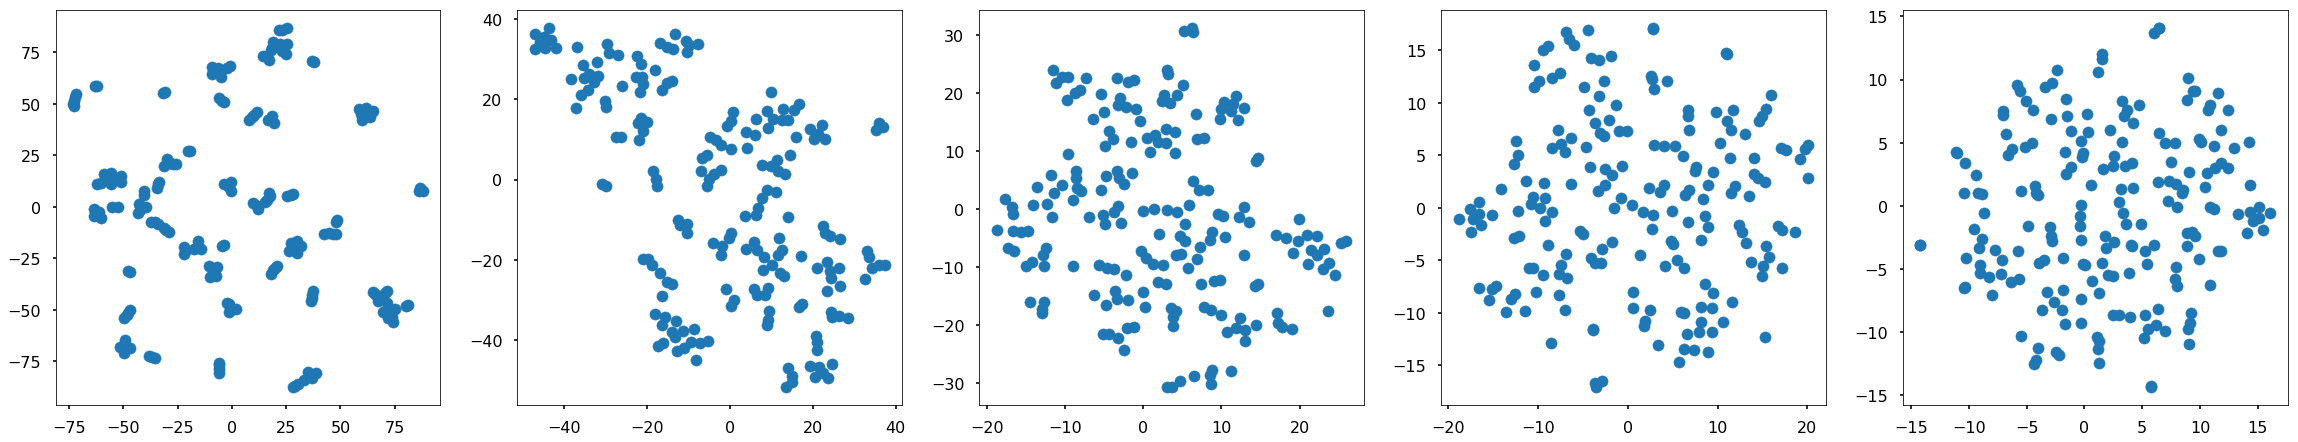

In [25]:
fig = plt.figure(figsize=(40, 16))
perplexities = [2, 10, 20, 30, 50]
for i in range(5):
    # Use tsne for dimension reductiona
    manifold_tsne = manifold.TSNE(
        n_components=2, n_iter=2000, perplexity=perplexities[i])
    out = manifold_tsne.fit_transform(tfidf_score_array)
    x, y = np.hsplit(out, 2)

    ax = plt.subplot(2, 5, i + 1)
    ax.scatter(x, y)


    
for j in range(5):
    # Use tsne for dimension reductiona
    manifold_tsne = manifold.TSNE(
        n_components=2,
        n_iter=2000,
        perplexity=perplexities[i],
        metric='precomputed')
    out = manifold_tsne.fit_transform(convert_sim2dist(sim_matrix))
    x, y = np.hsplit(out, 2)

    ax = plt.subplot(2, 5, i + j + 2)
    ax.scatter(x, y)

### Similarity matrix

In [22]:
from scipy.spatial.distance import cosine

In [23]:
def _to_list(l, target_length):
    """
    List of tuples...
    """
    out = np.zeros(target_length, dtype=np.float32)
    for (i, v) in l:
        out[i] = v
    return out

In [24]:
_to_list([(1,2.3),(0,5)], 5)

array([5. , 2.3, 0. , 0. , 0. ], dtype=float32)

In [25]:
target_length = len(tfidf_metada.idfs.values())
num_individuals = len(df_pubmapping_4_collabgraph)
sim_matrix = np.zeros([num_individuals, num_individuals])

for i in range(num_individuals):
    a = _to_list(df_pubmapping_4_collabgraph.tfidf.iloc[i], target_length)
    for j in range(num_individuals):
        b = _to_list(df_pubmapping_4_collabgraph.tfidf.iloc[j], target_length)
        sim_matrix[i][j] = 1. - cosine(a, b)
    sim_matrix[i][i] = 0

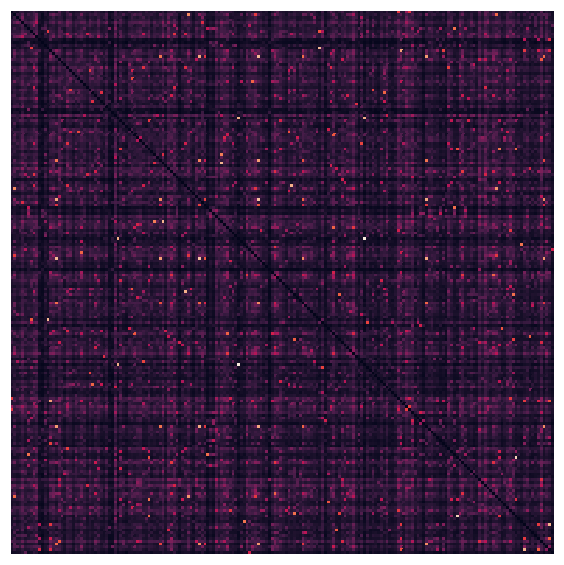

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/tfidf_embedding.png', format='png', transparent=True, bbox_inches='tight')

In [27]:
np.max(sim_matrix)

1.0

In [28]:
np.min(sim_matrix)

0.0

### Comparison with ground-truth collab-net:

In [30]:
ground_truth_adj_mat = np.load(os.path.join(DATA_DIR, 'mat', 'infnet20yrs-adj-mat.pkl'))

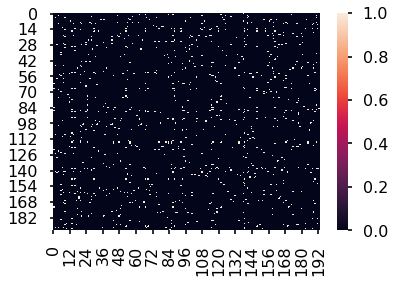

In [31]:
sns.heatmap(ground_truth_adj_mat)

In [32]:
# Count number of edges:
np.sum(ground_truth_adj_mat)

940.0

In [33]:
# We use Scipy.spatial.distance measure for jaccard dissimilarity (distance)
from scipy.spatial.distance import jaccard


def jaccard_dist(x_true, x, theta=None, binary=True):
    """
    Given vectors x_true and x of the same length, calculate the
    jaccard distance between x_true and x.
    Theta is represents the threshold parameter to filter x by. 
    If given, any values in x < theta will be set to 0
    """
    x = np.array(x)
    if binary:
        if theta:
            idx = x < theta
            x[idx] = False
            x[~idx] = True
#             print(x)
            return jaccard(x_true, x), np.sum(x, dtype=int) # np.sum(x) = number of edges (1s)
        else:
            return jaccard(x_true, x)
    else:
        print("not implemented")

In [34]:
x_true = [0, 0, 1]
x = [0., .1, .2]
jaccard_dist(x_true, x, theta=.2)[0] == jaccard([0,0,1],[0,0,1])

True

In [35]:
jaccard_dist(x_true, x, theta=.2)[1]

1

In [36]:
def find_best_threshold(x_trues,
                        xs,
                        start_threshold=0.005,
                        step_size=0.005,
                        num_iter=100):
    """
    An iterative approach to find the best threshold such that x is the most similar to x
    
    We aim to minimise the average jaccard_distance that we calculated. but increasing 
    or decreasing the threshold every iteration, starting from start_threshold.
    
    Stops after num_iter, or when the threshold is greater than 1.
    """
    # Initialise the parameters
    end_conditions = True
    lowest_avg_distance = 1  # maximum possible
    maximum_edges = np.shape(xs)[0] * np.shape(xs)[1]  # maximum now..
    threshold = start_threshold
    best_threshold = 0.
    epoch = 0
    best_epoch = 0
    _NUM_EDGES = []
    _AVG_DISTANCES = []
    _THRESHOLDS = []

    while (end_conditions):

        distances = np.zeros(x_trues.shape[0])  # store the average distances
        i = 0
        num_edges = 0  # calculate the number of edges for this threshold.

        for x_true, x in zip(ground_truth_adj_mat, sim_matrix):
            dist, num_edge = jaccard_dist(
                x_true, x, theta=threshold, binary=True)
            distances[i] = dist
            num_edges += num_edge
            i += 1
        # calculate the mean:
        average_dist = np.mean(distances)
        _NUM_EDGES.append(num_edges)
        _THRESHOLDS.append(threshold)
        _AVG_DISTANCES.append(average_dist)
        print(("epoch {}: threshold: {:.3f} avg_dist: {:.3f} num_edges: {}".
               format(epoch, threshold, average_dist, num_edges)))

        # check if the best epoch is seen
        #         if (average_dist < lowest_avg_distance):
        #             best_epoch = epoch
        #             lowest_avg_distance = average_dist
        #             best_threshold = threshold
        if (num_edges >= np.sum(x_trues)):
            best_epoch = epoch
            best_threshold = threshold
            maximum_edges = num_edges

        # Next iteration
        epoch += 1
        threshold += step_size
        end_conditions = (epoch < num_iter) and (threshold <= 1.)


#         end_conditions = (epoch < num_iter) and (maximum_edges >= 1)

    print(('Best epoch: {}: threshold: {:.3f} dist {:3f} edges {}'.format(
        best_epoch, best_threshold, lowest_avg_distance, maximum_edges)))
    return _THRESHOLDS, _NUM_EDGES, _AVG_DISTANCES

In [37]:
thresholds, edges, distances = find_best_threshold(
    ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: threshold: 0.005 avg_dist: 0.975 num_edges: 37440
epoch 1: threshold: 0.010 avg_dist: 0.975 num_edges: 37424
epoch 2: threshold: 0.015 avg_dist: 0.975 num_edges: 37344
epoch 3: threshold: 0.020 avg_dist: 0.975 num_edges: 37128
epoch 4: threshold: 0.025 avg_dist: 0.975 num_edges: 36772
epoch 5: threshold: 0.030 avg_dist: 0.974 num_edges: 36236
epoch 6: threshold: 0.035 avg_dist: 0.974 num_edges: 35632
epoch 7: threshold: 0.040 avg_dist: 0.974 num_edges: 34802
epoch 8: threshold: 0.045 avg_dist: 0.973 num_edges: 33960
epoch 9: threshold: 0.050 avg_dist: 0.972 num_edges: 32884
epoch 10: threshold: 0.055 avg_dist: 0.971 num_edges: 31804
epoch 11: threshold: 0.060 avg_dist: 0.970 num_edges: 30532
epoch 12: threshold: 0.065 avg_dist: 0.968 num_edges: 29276
epoch 13: threshold: 0.070 avg_dist: 0.966 num_edges: 28008
epoch 14: threshold: 0.075 avg_dist: 0.964 num_edges: 26722
epoch 15: threshold: 0.080 avg_dist: 0.962 num_edges: 25506
epoch 16: threshold: 0.085 avg_dist: 0.959 num_edg

epoch 147: threshold: 0.740 avg_dist: 0.958 num_edges: 46
epoch 148: threshold: 0.745 avg_dist: 0.958 num_edges: 44
epoch 149: threshold: 0.750 avg_dist: 0.958 num_edges: 44
epoch 150: threshold: 0.755 avg_dist: 0.960 num_edges: 42
epoch 151: threshold: 0.760 avg_dist: 0.961 num_edges: 40
epoch 152: threshold: 0.765 avg_dist: 0.964 num_edges: 36
epoch 153: threshold: 0.770 avg_dist: 0.964 num_edges: 36
epoch 154: threshold: 0.775 avg_dist: 0.964 num_edges: 36
epoch 155: threshold: 0.780 avg_dist: 0.964 num_edges: 36
epoch 156: threshold: 0.785 avg_dist: 0.965 num_edges: 34
epoch 157: threshold: 0.790 avg_dist: 0.966 num_edges: 32
epoch 158: threshold: 0.795 avg_dist: 0.966 num_edges: 32
epoch 159: threshold: 0.800 avg_dist: 0.967 num_edges: 30
epoch 160: threshold: 0.805 avg_dist: 0.968 num_edges: 28
epoch 161: threshold: 0.810 avg_dist: 0.968 num_edges: 28
epoch 162: threshold: 0.815 avg_dist: 0.969 num_edges: 26
epoch 163: threshold: 0.820 avg_dist: 0.969 num_edges: 26
epoch 164: thr

- epoch 66: threshold: 0.335 avg_dist: 0.638 num_edges: 1000
- epoch 67: threshold: 0.340 avg_dist: 0.644 num_edges: 938

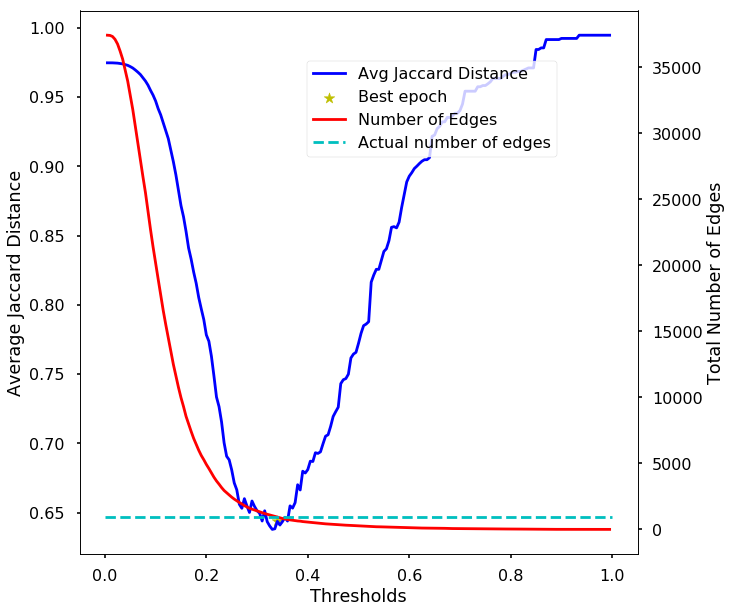

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(thresholds, distances, 'b')
ax.set_xlabel('Thresholds')
ax.set_ylabel('Average Jaccard Distance')
ax.scatter(0.340, 0.644, marker='*', c='y')
ax2 = ax.twinx()
ax2.plot(thresholds, edges, 'r-')
ax2.set_ylabel('Total Number of Edges')
ax2.plot(
    np.linspace(0, 1., 100),
    np.repeat(940, 100),
    'c--',
    label='Actual number of edges')
fig.legend(
    [
        'Avg Jaccard Distance', 'Best epoch',
        'Number of Edges', 'Actual number of edges'
    ],
    loc=10, bbox_to_anchor=(0.6,0.7))

fig.savefig('IMG/tfidf_jacccard_plot.png', format='png', bbox_inches='tight', transparent=True)

In [40]:
# Visualise the new heatmap!
threshold = thresholds[67]
sim_matrix_bin = np.ones(sim_matrix.shape)
sim_matrix_bin = np.where(sim_matrix<threshold,0,1)
np.fill_diagonal(sim_matrix_bin, 0)

In [41]:
np.sum(sim_matrix_bin)

938

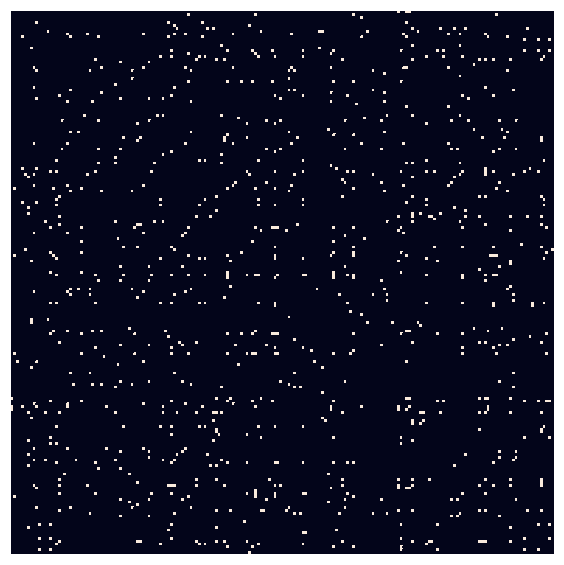

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix_bin,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/tfidf_embedding_threshold.png', format='png', transparent=True, bbox_inches='tight')

In [43]:
sim_matrix_bin.dump(os.path.join(DATA_DIR,'mat', 'tfidf_embedding_bin.pkl'))

## `METADATA` + `pdf2txt` too:

### Create corpus

In [34]:
dictionary_all = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.all'))

In [35]:
concat_toks = [
    a + b for a, b in zip(lookup_combined_toks.toks_metada.tolist(),
                          lookup_combined_toks.toks_pdf2txt.tolist())
]

In [37]:
tfidf_all = TfidfModel(dictionary=dictionary_all, normalize=True)
tfidf_all.save(os.path.join(DATA_DIR, 'models', 'tfidf', 'tfidf_all'))

In [38]:
corpus_bows = [dictionary_all.doc2bow(doc) for doc in concat_toks]

### Generate tfidf score for each individual

In [39]:
_indices = set(lookup_combined_toks.index)

def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]

    # Constraint to 1997-2017
    out = []
    for a,b in zip(_df.toks_metada.tolist(),_df.toks_pdf2txt.tolist()):
        out += a + b
    return out

In [40]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [41]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_all[dictionary_all.doc2bow(x)] if len(x) else None
    )

### Similarity Matrix

In [42]:
index = sim.Similarity(
    output_prefix='20yrs_metadata',
    corpus=df_pubmapping_4_collabgraph.tfidf.tolist(),
    num_features=len(dictionary_all))

In [43]:
index.save(os.path.join(DATA_DIR, 'models', 'index_20yrs_all'))

### Visualisation

In [44]:
sim_matrix = []
for i in range(len(df_pubmapping_4_collabgraph)):
    sim_matrix.append(index[df_pubmapping_4_collabgraph.tfidf.iloc[i]])

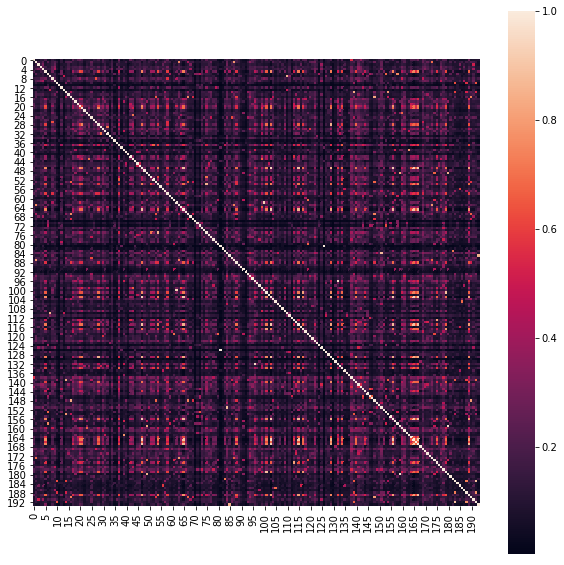

In [46]:
sim_matrix = np.array(sim_matrix)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(sim_matrix, ax=ax, square=True)

### Comparison with ground-truth

In [47]:
find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: avg_dist: 0.975 threshold: 0.010
epoch 1: avg_dist: 0.975 threshold: 0.015
epoch 2: avg_dist: 0.975 threshold: 0.020
epoch 3: avg_dist: 0.974 threshold: 0.025
epoch 4: avg_dist: 0.974 threshold: 0.030
epoch 5: avg_dist: 0.973 threshold: 0.035
epoch 6: avg_dist: 0.972 threshold: 0.040
epoch 7: avg_dist: 0.972 threshold: 0.045
epoch 8: avg_dist: 0.971 threshold: 0.050
epoch 9: avg_dist: 0.970 threshold: 0.055
epoch 10: avg_dist: 0.968 threshold: 0.060
epoch 11: avg_dist: 0.967 threshold: 0.065
epoch 12: avg_dist: 0.965 threshold: 0.070
epoch 13: avg_dist: 0.963 threshold: 0.075
epoch 14: avg_dist: 0.960 threshold: 0.080
epoch 15: avg_dist: 0.957 threshold: 0.085
epoch 16: avg_dist: 0.955 threshold: 0.090
epoch 17: avg_dist: 0.951 threshold: 0.095
epoch 18: avg_dist: 0.948 threshold: 0.100
epoch 19: avg_dist: 0.945 threshold: 0.105
epoch 20: avg_dist: 0.940 threshold: 0.110
epoch 21: avg_dist: 0.935 threshold: 0.115
epoch 22: avg_dist: 0.932 threshold: 0.120
epoch 23: avg_dist: 0

best epoch: 69: dist 0.750555 threshold: 0.355

---

# Topic models

In [45]:
from gensim import models

## Model2 : metadata only (1997-2017)

In [46]:
tm_model2 = models.LdaModel.load(os.path.join(DATA_DIR, 'models', 'tm', 'tm_model2'))

In [47]:
dict_meta = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.meta'))

In [48]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [49]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [50]:
tm_model2.minimum_probability = 0.01 # change the probabilty that we set to 0.01, instead of 0.9

In [51]:
df_pubmapping_4_collabgraph[
    'tm_model2'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tm_model2.get_document_topics(dict_meta.doc2bow(x)) if len(x) else None
    )

In [52]:
target_length = tm_model2.num_topics
num_individuals = len(df_pubmapping_4_collabgraph)
sim_matrix = np.zeros([num_individuals, num_individuals])

for i in range(num_individuals):
    a = _to_list(df_pubmapping_4_collabgraph.tm_model2.iloc[i], target_length)
    for j in range(num_individuals):
        b = _to_list(df_pubmapping_4_collabgraph.tm_model2.iloc[j], target_length)
        sim_matrix[i][j] = 1. - cosine(a,b)
    sim_matrix[i][i] = 0

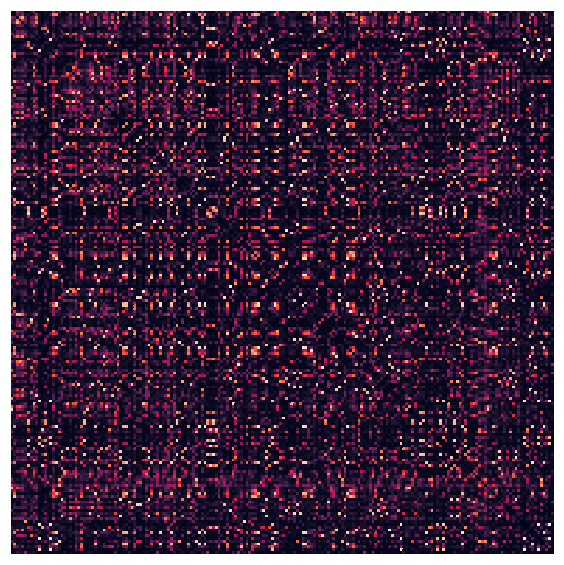

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix,
    ax=ax,
    square=True,
    yticklabels="",
    #     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False)
fig.savefig(
    'IMG/model2_embedding.png',
    format='png',
    transparent=True,
    bbox_inches='tight')

### Comparison with ground_truth

In [54]:
thresholds, edges, distances = find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: threshold: 0.005 avg_dist: 0.972 num_edges: 33554
epoch 1: threshold: 0.010 avg_dist: 0.969 num_edges: 31002
epoch 2: threshold: 0.015 avg_dist: 0.967 num_edges: 28788
epoch 3: threshold: 0.020 avg_dist: 0.964 num_edges: 27028
epoch 4: threshold: 0.025 avg_dist: 0.962 num_edges: 25430
epoch 5: threshold: 0.030 avg_dist: 0.960 num_edges: 23992
epoch 6: threshold: 0.035 avg_dist: 0.957 num_edges: 22706
epoch 7: threshold: 0.040 avg_dist: 0.955 num_edges: 21548
epoch 8: threshold: 0.045 avg_dist: 0.952 num_edges: 20386
epoch 9: threshold: 0.050 avg_dist: 0.949 num_edges: 19348
epoch 10: threshold: 0.055 avg_dist: 0.947 num_edges: 18420
epoch 11: threshold: 0.060 avg_dist: 0.944 num_edges: 17532
epoch 12: threshold: 0.065 avg_dist: 0.942 num_edges: 16756
epoch 13: threshold: 0.070 avg_dist: 0.940 num_edges: 16044
epoch 14: threshold: 0.075 avg_dist: 0.938 num_edges: 15404
epoch 15: threshold: 0.080 avg_dist: 0.935 num_edges: 14796
epoch 16: threshold: 0.085 avg_dist: 0.933 num_edg

epoch 166: threshold: 0.835 avg_dist: 0.826 num_edges: 800
epoch 167: threshold: 0.840 avg_dist: 0.828 num_edges: 778
epoch 168: threshold: 0.845 avg_dist: 0.831 num_edges: 762
epoch 169: threshold: 0.850 avg_dist: 0.831 num_edges: 734
epoch 170: threshold: 0.855 avg_dist: 0.837 num_edges: 712
epoch 171: threshold: 0.860 avg_dist: 0.834 num_edges: 690
epoch 172: threshold: 0.865 avg_dist: 0.832 num_edges: 652
epoch 173: threshold: 0.870 avg_dist: 0.838 num_edges: 620
epoch 174: threshold: 0.875 avg_dist: 0.837 num_edges: 588
epoch 175: threshold: 0.880 avg_dist: 0.838 num_edges: 564
epoch 176: threshold: 0.885 avg_dist: 0.839 num_edges: 550
epoch 177: threshold: 0.890 avg_dist: 0.841 num_edges: 518
epoch 178: threshold: 0.895 avg_dist: 0.841 num_edges: 486
epoch 179: threshold: 0.900 avg_dist: 0.842 num_edges: 472
epoch 180: threshold: 0.905 avg_dist: 0.843 num_edges: 442
epoch 181: threshold: 0.910 avg_dist: 0.841 num_edges: 408
epoch 182: threshold: 0.915 avg_dist: 0.844 num_edges: 3

- epoch 158: threshold: 0.795 avg_dist: 0.818 num_edges: 956
- epoch 159: threshold: 0.800 avg_dist: 0.819 num_edges: 934

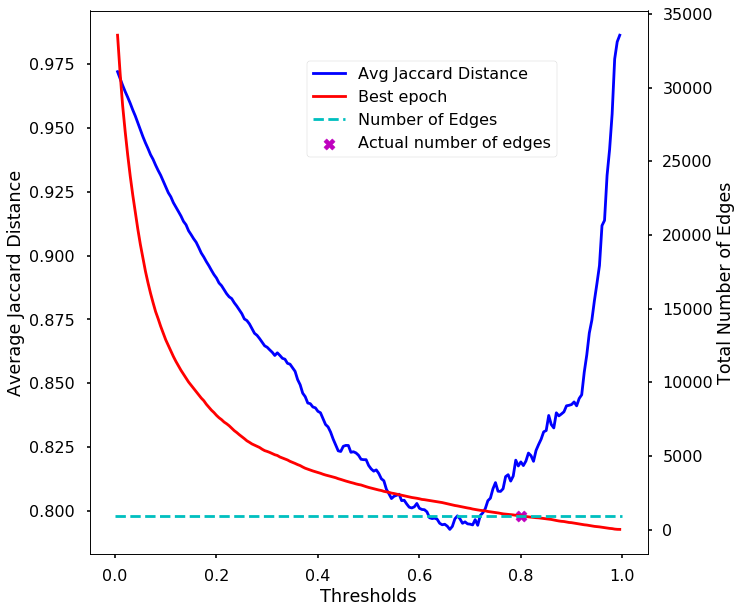

In [59]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(thresholds, distances, 'b')
ax.set_xlabel('Thresholds')
ax.set_ylabel('Average Jaccard Distance')
ax2 = ax.twinx()
ax2.plot(thresholds, edges, 'r-')
ax2.set_ylabel('Total Number of Edges')
ax2.plot(
    np.linspace(0, 1., 100),
    np.repeat(940, 100),
    'c--',
    label='Actual number of edges')
ax2.scatter(0.8, 934, marker='X', c='m')
fig.legend(
    [
        'Avg Jaccard Distance', 'Best epoch',
        'Number of Edges', 'Actual number of edges'
    ],
    loc=10, bbox_to_anchor=(0.6,0.7))

fig.savefig('IMG/tm_model2_jacccard_plot.png', format='png', bbox_inches='tight', transparent=True)

In [60]:
# Visualise the new heatmap!
threshold = thresholds[159]
sim_matrix_bin = np.ones(sim_matrix.shape)
sim_matrix_bin = np.where(sim_matrix < threshold, 0, 1)
np.fill_diagonal(sim_matrix_bin, 0)

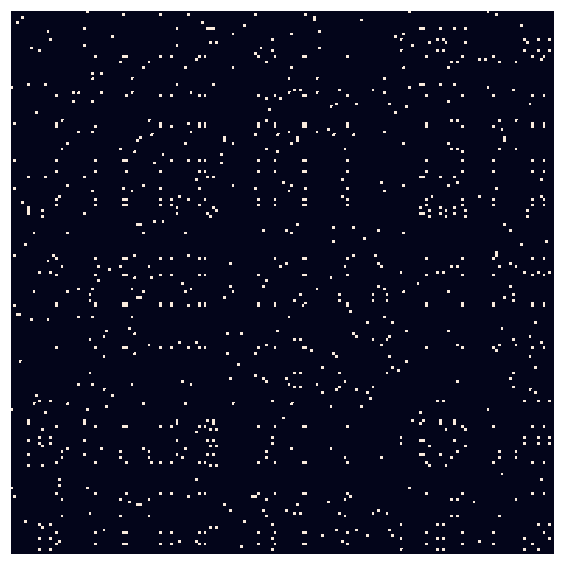

In [61]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix_bin,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/tm_model2_embedding_threshold.png', format='png', transparent=True, bbox_inches='tight')

In [62]:
sim_matrix_bin.dump(os.path.join(DATA_DIR,'mat','tm_model2_embedding_bin.pkl'))

## DBLP topic model

In [63]:
DATA_DIR = '../../data/data_dblp/'

In [64]:
dict_dblp = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.dblp.1997-2017'))

In [65]:
len(dict_dblp)

76471

In [66]:
tm_dblp = models.LdaModel.load(
    os.path.join(DATA_DIR, 'models', 'tm', 'tm_dblp'))
tm_dblp.minimum_probability = 0.01 # change the probabilty that we set to 0.01, instead of 0.9

In [67]:
_indices = set(lookup_combined_toks.index)


def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [68]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [69]:
len(tm_dblp.id2word)

76471

In [70]:
df_pubmapping_4_collabgraph[
    'tm_dblp'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tm_dblp.get_document_topics(dict_dblp.doc2bow(x)) if len(x) else None
    )

In [71]:
target_length = tm_dblp.num_topics
num_individuals = len(df_pubmapping_4_collabgraph)
sim_matrix = np.zeros([num_individuals, num_individuals])

for i in range(num_individuals):
    a = _to_list(df_pubmapping_4_collabgraph.tm_dblp.iloc[i], target_length)
    for j in range(num_individuals):
        b = _to_list(df_pubmapping_4_collabgraph.tm_dblp.iloc[j], target_length)
        sim_matrix[i][j] = 1. - cosine(a,b)
    sim_matrix[i][i] = 0.

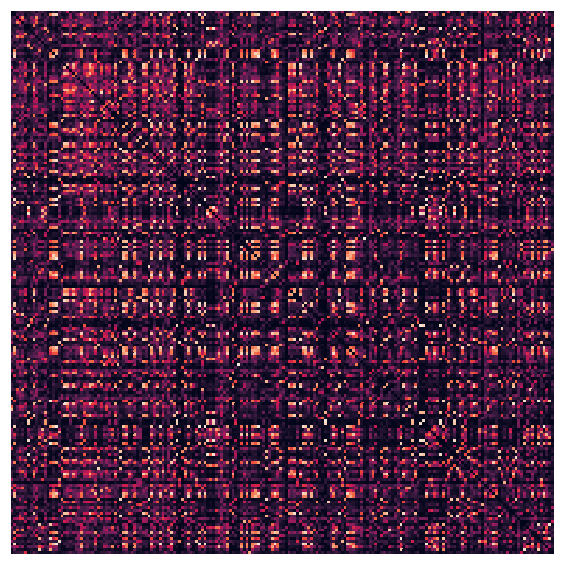

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/model_dblp_embedding.png', format='png', transparent=True, bbox_inches='tight')

### Comparison with ground truth

In [74]:
thresholds, edges, distances = find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: threshold: 0.005 avg_dist: 0.974 num_edges: 36210
epoch 1: threshold: 0.010 avg_dist: 0.973 num_edges: 35066
epoch 2: threshold: 0.015 avg_dist: 0.972 num_edges: 33962
epoch 3: threshold: 0.020 avg_dist: 0.972 num_edges: 32916
epoch 4: threshold: 0.025 avg_dist: 0.971 num_edges: 31994
epoch 5: threshold: 0.030 avg_dist: 0.970 num_edges: 31086
epoch 6: threshold: 0.035 avg_dist: 0.969 num_edges: 30156
epoch 7: threshold: 0.040 avg_dist: 0.968 num_edges: 29236
epoch 8: threshold: 0.045 avg_dist: 0.967 num_edges: 28374
epoch 9: threshold: 0.050 avg_dist: 0.966 num_edges: 27582
epoch 10: threshold: 0.055 avg_dist: 0.964 num_edges: 26786
epoch 11: threshold: 0.060 avg_dist: 0.963 num_edges: 25956
epoch 12: threshold: 0.065 avg_dist: 0.962 num_edges: 25204
epoch 13: threshold: 0.070 avg_dist: 0.961 num_edges: 24514
epoch 14: threshold: 0.075 avg_dist: 0.960 num_edges: 23806
epoch 15: threshold: 0.080 avg_dist: 0.958 num_edges: 23090
epoch 16: threshold: 0.085 avg_dist: 0.957 num_edg

epoch 143: threshold: 0.720 avg_dist: 0.804 num_edges: 2162
epoch 144: threshold: 0.725 avg_dist: 0.803 num_edges: 2112
epoch 145: threshold: 0.730 avg_dist: 0.805 num_edges: 2048
epoch 146: threshold: 0.735 avg_dist: 0.805 num_edges: 1990
epoch 147: threshold: 0.740 avg_dist: 0.811 num_edges: 1926
epoch 148: threshold: 0.745 avg_dist: 0.811 num_edges: 1862
epoch 149: threshold: 0.750 avg_dist: 0.811 num_edges: 1818
epoch 150: threshold: 0.755 avg_dist: 0.812 num_edges: 1778
epoch 151: threshold: 0.760 avg_dist: 0.811 num_edges: 1728
epoch 152: threshold: 0.765 avg_dist: 0.812 num_edges: 1672
epoch 153: threshold: 0.770 avg_dist: 0.812 num_edges: 1626
epoch 154: threshold: 0.775 avg_dist: 0.816 num_edges: 1578
epoch 155: threshold: 0.780 avg_dist: 0.821 num_edges: 1524
epoch 156: threshold: 0.785 avg_dist: 0.817 num_edges: 1472
epoch 157: threshold: 0.790 avg_dist: 0.817 num_edges: 1406
epoch 158: threshold: 0.795 avg_dist: 0.817 num_edges: 1354
epoch 159: threshold: 0.800 avg_dist: 0.

- epoch 168: threshold: 0.845 avg_dist: 0.843 num_edges: 946
- epoch 169: threshold: 0.850 avg_dist: 0.854 num_edges: 888

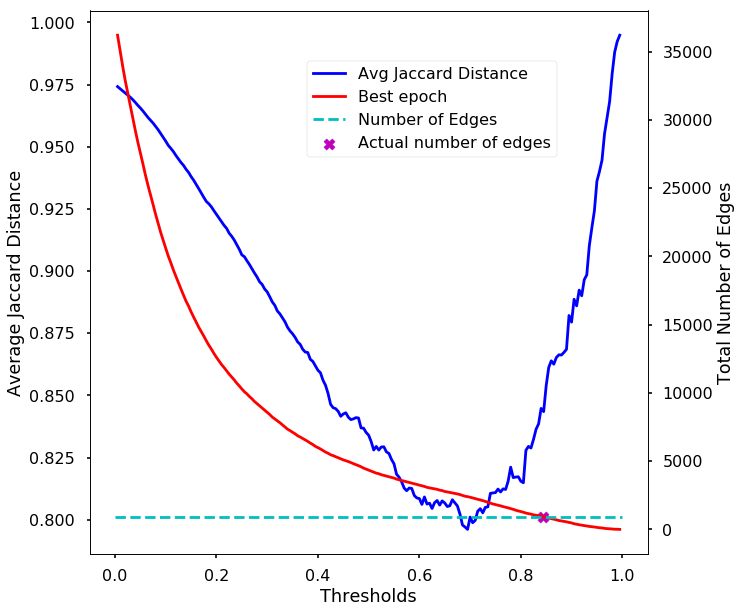

In [76]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(thresholds, distances, 'b')
ax.set_xlabel('Thresholds')
ax.set_ylabel('Average Jaccard Distance')
ax2 = ax.twinx()
ax2.plot(thresholds, edges, 'r-')
ax2.set_ylabel('Total Number of Edges')
ax2.plot(
    np.linspace(0, 1., 100),
    np.repeat(940, 100),
    'c--',
    label='Actual number of edges')
ax2.scatter(0.843, 946, marker='X', c='m')
fig.legend(
    [
        'Avg Jaccard Distance', 'Best epoch',
        'Number of Edges', 'Actual number of edges'
    ],
    loc=10, bbox_to_anchor=(0.6,0.7))

fig.savefig('IMG/tm_dblp_jacccard_plot.png', format='png', bbox_inches='tight', transparent=True)

In [77]:
# Visualise the new heatmap!
threshold = thresholds[168]
sim_matrix_bin = np.ones(sim_matrix.shape)
sim_matrix_bin = np.where(sim_matrix < threshold, 0, 1)
np.fill_diagonal(sim_matrix_bin, 0)

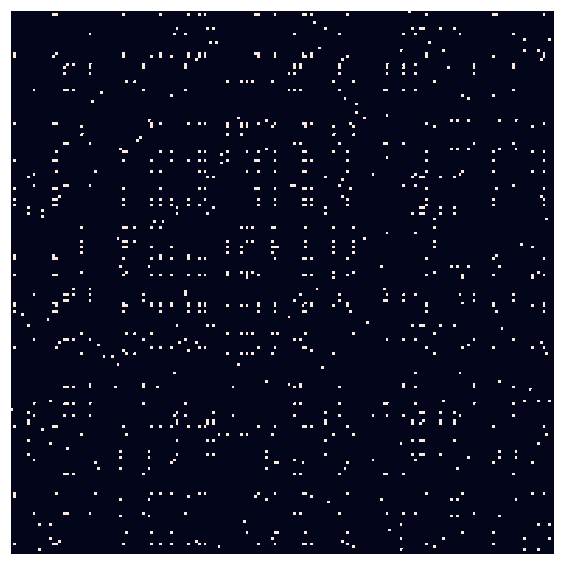

In [78]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    sim_matrix_bin,
    ax=ax,
    square=True,
    yticklabels="",
#     yticklabels=df_pubmapping_4_collabgraph.index,
    xticklabels="",
    cbar=False
)
fig.savefig('IMG/tm_dblp_embedding_threshold.png', format='png', transparent=True, bbox_inches='tight')

In [80]:
sim_matrix_bin.dump(os.path.join(DATA_DIR,'mat','tm_dblp_embedding_bin.pkl'))

# Summary of results compared to ground truth of informatics collab network

|Model |Average Jaccard Distance* | Threshold required | 
|---|---|---|
|tfidf (metadata) | 0.703 | 0.330|
|tfidf (metadata+pdf) | 0.751 |0.355 |
| Topic model (metadata) |0.816 |0.660 |
| Topic model (dblp) | 0.829 | 0.695 |

- [ ] Filter the topic model to reduce noise?
- [ ] Does this necessarily means it is not good?

## Visualise networks induce from embeddings: